In [54]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from fbprophet import Prophet
std=StandardScaler() 

In [55]:
covid=pd.read_csv("covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.000000,0.000000,0.000000
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.000000,0.000000,0.000000
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.000000,0.000000,0.000000


In [56]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (48095, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     19705
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [57]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)

In [58]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [59]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [60]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [61]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [62]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])


Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  9098641.0
Total number of Recovered Cases around the World:  4526333.0
Total number of Deaths Cases around the World:  472171.0
Total number of Active Cases around the World:  4100137.0
Total number of Closed Cases around the World:  4998504.0


In [63]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

Text(0.5, 1.0, 'Top 10 countries as per Number of recoverd Cases')

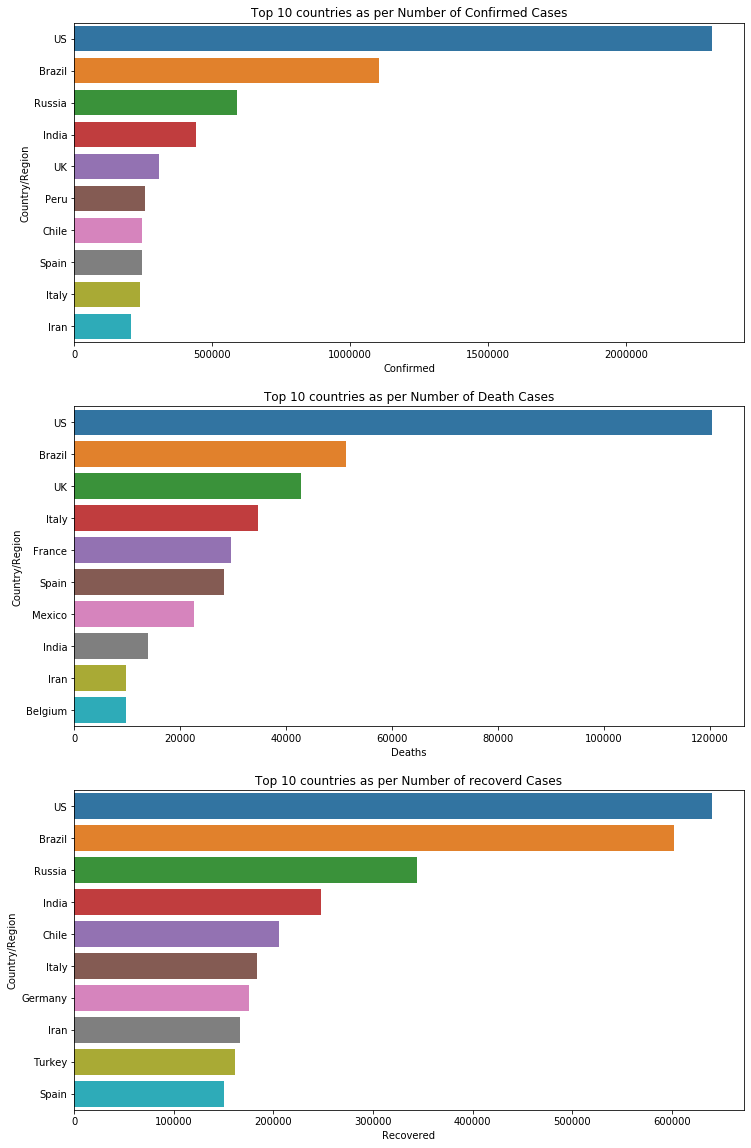

In [64]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(12,20))
top_10_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(10)
top_10_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(10)
top_10_recovery=countrywise.sort_values(["Recovered"],ascending=False).head(10)
sns.barplot(x=top_10_confirmed["Confirmed"],y=top_10_confirmed.index,ax=ax1)
ax1.set_title("Top 10 countries as per Number of Confirmed Cases")
sns.barplot(x=top_10_deaths["Deaths"],y=top_10_deaths.index,ax=ax2)
ax2.set_title("Top 10 countries as per Number of Death Cases")
sns.barplot(x=top_10_recovery["Recovered"],y=top_10_recovery.index,ax=ax3)
ax3.set_title("Top 10 countries as per Number of recoverd Cases")


Text(0.5, 0, 'Recovery (in Percentage)')

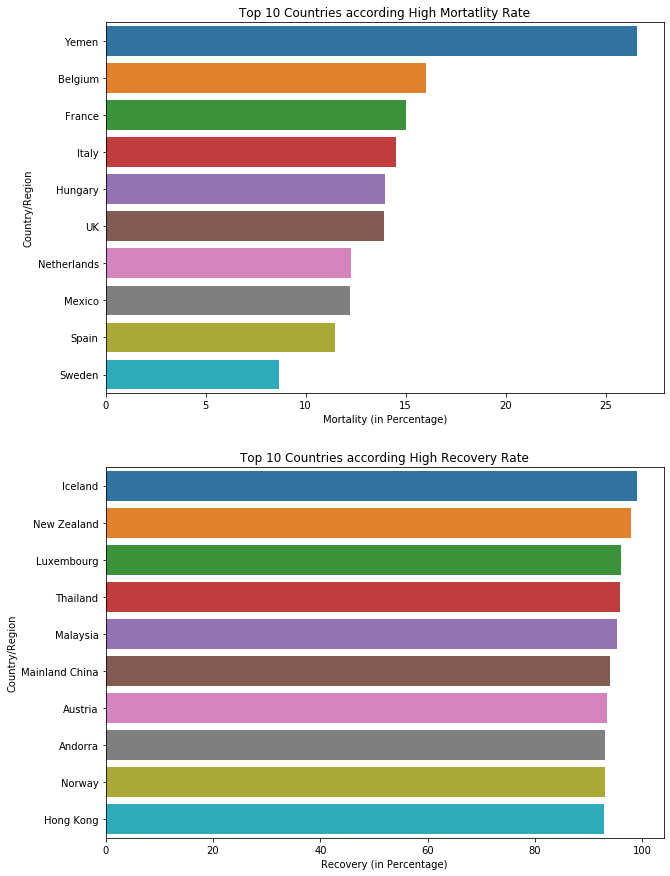

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).head(10)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 10 Countries according High Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>500].sort_values(["Recovery"],ascending=False).head(10)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 10 Countries according High Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")

In [66]:
india_data=covid[covid["Country/Region"]=="India"]
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])
india_data

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
430,2020-01-30,NaN,India,1/30/20 16:00,1.000000,0.000000,0.000000
491,2020-01-31,NaN,India,1/31/2020 23:59,1.000000,0.000000,0.000000
547,2020-02-01,NaN,India,1/31/2020 8:15,1.000000,0.000000,0.000000
607,2020-02-02,NaN,India,2020-02-02T06:03:08,2.000000,0.000000,0.000000
672,2020-02-03,NaN,India,2020-02-03T21:43:02,3.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
48027,2020-06-22,Tripura,India,2020-06-23 04:33:22,1237.000000,1.000000,782.000000
48041,2020-06-22,Unknown,India,2020-06-23 04:33:22,8015.000000,0.000000,0.000000
48048,2020-06-22,Uttar Pradesh,India,2020-06-23 04:33:22,18322.000000,569.000000,11601.000000
48049,2020-06-22,Uttarakhand,India,2020-06-23 04:33:22,2402.000000,28.000000,1521.000000


In [67]:
datewise=india_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [68]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [69]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [70]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
lin_reg=LinearRegression(normalize=True)

In [71]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [72]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [73]:
from sklearn.metrics import mean_squared_error,r2_score
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  215557.29207098804


In [74]:
import plotly.graph_objects as go
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='red')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [75]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [76]:
from sklearn.svm import SVR
#Intializing SVR Model
svr=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

In [77]:
#Fitting model on the training data
svr.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
prediction_valid_svr=svr.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [79]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svr)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svr)))

Root Mean Square Error for Support Vectore Machine:  10585.18531606216


In [80]:
plt.figure(figsize=(11,6))
prediction_svr=svr.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svr,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='red')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [81]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [82]:
from pmdarima.arima import auto_arima
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=4,max_q=4,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=2537.568, BIC=2543.378, Time=0.014 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=2407.523, BIC=2416.239, Time=0.128 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=2328.068, BIC=2339.689, Time=0.185 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=2316.826, BIC=2331.353, Time=0.253 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=2311.901, BIC=2329.333, Time=0.325 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=2400.491, BIC=2409.207, Time=0.024 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=2334.756, BIC=2346.377, Time=0.209 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=2313.039, BIC=2327.565, Time=0.125 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=2306.170, BIC=2323.601, Time=0.280 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=2318.585, BIC=2338.922, Time=0.356 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=2304.607, BIC=2316.228, Time=0.

ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [83]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [84]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  33855.398160602665


In [85]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [86]:
from fbprophet import Prophet
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [87]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [89]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [90]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  5182.893607632271


Figure(720x432)


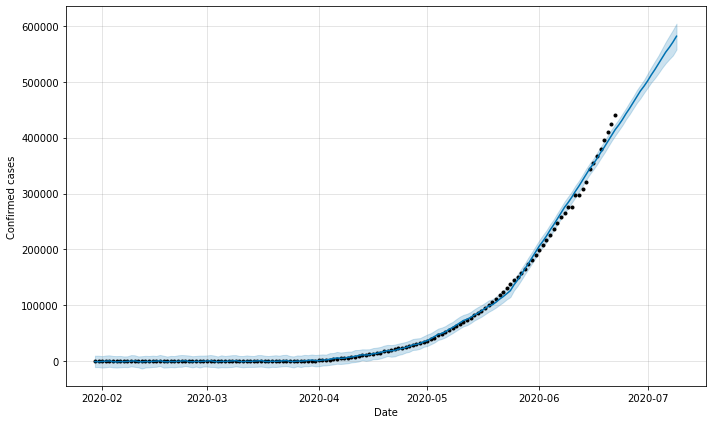

In [91]:
print(prophet_c.plot(confirmed_forecast, xlabel='Date', ylabel='Confirmed cases'))

In [92]:
model_names=["Linear Regression","Support Vector Machine Regressor","ARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
3,Facebook's Prophet Model,5182.893608
1,Support Vector Machine Regressor,10585.185316
2,ARIMA Model,33855.398161
0,Linear Regression,215557.292071


In [93]:
from datetime import timedelta
new_date=[]
new_prediction_lr=[]
new_prediction_svr=[]
ARIMA_model_new_prediction=[]
new_prediction_prophets=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svr.append(svr.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])


In [94]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_svr,ARIMA_model_new_prediction),
                               columns=["Dates","Linear Regression Prediction","SVM Prediction","ARIMA Prediction"])
model_predictions

,Dates,Linear Regression Prediction,SVM Prediction,ARIMA Prediction
0,2020-06-23,183428.290501,442791.519298,406710.756305
1,2020-06-24,185129.893003,458333.964429,403265.333352
2,2020-06-25,186831.495506,474308.113347,424969.690786
3,2020-06-26,188533.098008,490722.897434,425562.615165
4,2020-06-27,190234.700511,507587.370416,439479.041155
5,2020-06-28,191936.303013,524910.709198,450640.141033
6,2020-06-29,193637.905516,542702.214694,453746.263721
7,2020-06-30,195339.508018,560971.312657,474422.451189
8,2020-07-01,197041.110520,579727.554517,471637.918429
9,2020-07-02,198742.713023,598980.618211,493987.415009


In [46]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].head(17))
model_predictions

,Dates,Linear Regression Prediction,SVM Prediction,ARIMA Prediction,Prophet's Prediction
0,2020-06-23,183428.290501,442791.519298,406710.756305,-403.821587
1,2020-06-24,185129.893003,458333.964429,403265.333352,-697.711525
2,2020-06-25,186831.495506,474308.113347,424969.690786,-307.782208
3,2020-06-26,188533.098008,490722.897434,425562.615165,235.160658
4,2020-06-27,190234.700511,507587.370416,439479.041155,812.780588
5,2020-06-28,191936.303013,524910.709198,450640.141033,-585.754340
6,2020-06-29,193637.905516,542702.214694,453746.263721,-1006.007738
7,2020-06-30,195339.508018,560971.312657,474422.451189,-311.971068
8,2020-07-01,197041.110520,579727.554517,471637.918429,-605.861024
9,2020-07-02,198742.713023,598980.618211,493987.415009,-215.931724
